# Проект для «Викишоп» с BERT и без неё

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем необходимые библиотеки, зафиксируем рандомстейт.

In [5]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import spacy
import torch

from catboost import CatBoostClassifier
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    precision_score, 
    recall_score
)
from sklearn.model_selection import (
    GridSearchCV, 
    StratifiedKFold, 
    train_test_split
)
from sklearn.pipeline import Pipeline
from transformers import (
    BertConfig, 
    BertModel, 
    BertTokenizer
)
from tqdm import notebook
from wordcloud import WordCloud

In [6]:
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 500)

In [7]:
RANDOM_STATE = 42

### Загрузка и предобработка данных

Считаем CSV-файл с данными и сохраним его в датафрейм `toxic_comments_df`.

In [10]:
csv_local = 'datasets/toxic_comments.csv'
csv_remote = 'https://example.com/datasets/toxic_comments.csv'
if os.path.exists(csv_local):
    toxic_comments_df = pd.read_csv(csv_local, index_col=0)
else:
    toxic_comments_df = pd.read_csv(csv_remote, index_col=0)

In [11]:
toxic_comments_df.head(5)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


Датафрейм `toxic_comments_df`с набором данных с разметкой о токсичности правок содержит следующие признаки:
- `text` — текст комментария;
- `toxic` — токсичность, **целевой признак**.

Изучим общую информацию о датафрейме.

In [14]:
toxic_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Пропусков нет, всего 159 292 комментариев.

Проверим дубликаты.

In [17]:
toxic_comments_df.index.duplicated().sum(), toxic_comments_df.duplicated().sum()

(0, 0)

Дубликатов нет.

### Анализ данных

#### Токсичность

Посмотрим на распределение целевого признака `toxic`.

In [22]:
(toxic_comments_df['toxic'].value_counts(normalize=True).round(4) * 100).map(str) + '%'

toxic
0    89.84%
1    10.16%
Name: proportion, dtype: object

Очевидный дисбаланс классов. Важно не забыть про **стратификацию данных**.

#### Длина комментариев

Построим диаграмму размаха длины комментариев.

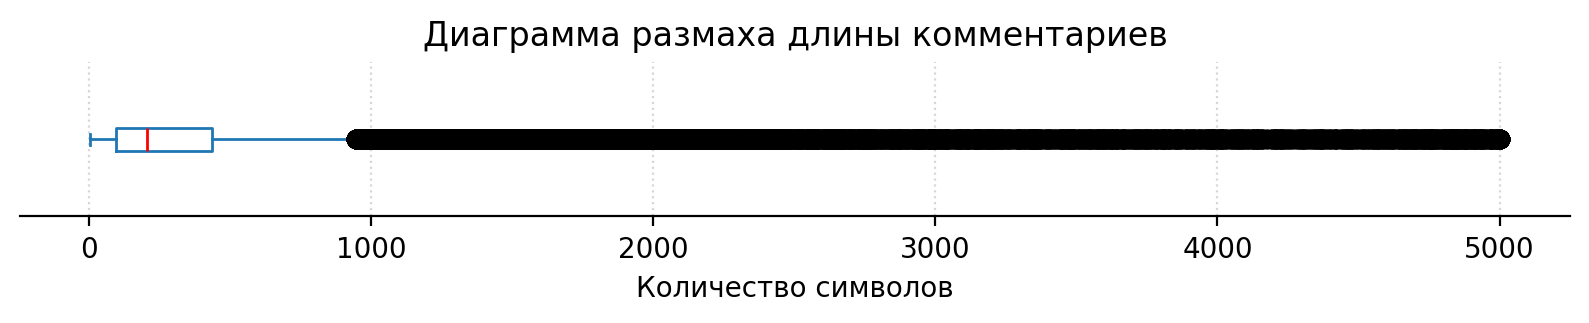

In [26]:
toxic_comments_df['text_len'] = toxic_comments_df['text'].str.len()

fig, ax = plt.subplots(figsize=(10, 1))
toxic_comments_df['text_len'].plot(kind='box', vert=False, ax=ax, medianprops={'color': 'red'})
ax.set_title('Диаграмма размаха длины комментариев')
ax.set_xlabel('Количество символов')
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x', alpha=0.5, linestyle=':')
plt.show()

Посмотрим на распределение комментариев по длине с разбивкой по целевому признаку `toxic`.

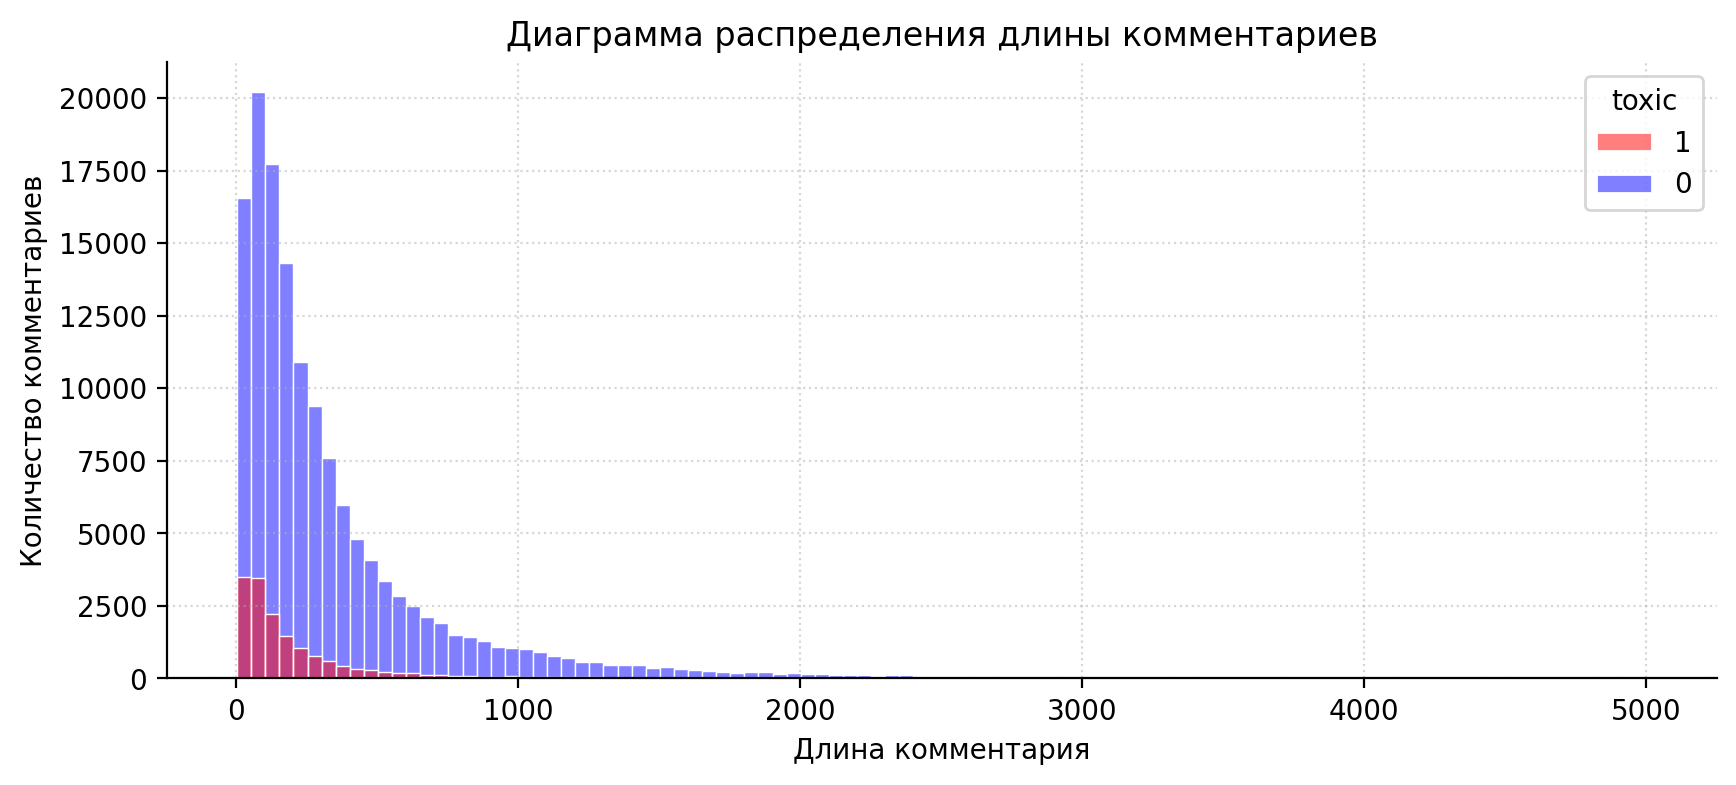

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.histplot(x=toxic_comments_df['text_len'], 
             hue=toxic_comments_df['toxic'],
             hue_order=[1, 0], palette=['red', 'blue'],
             bins=100, edgecolor='white', ax=ax)
ax.set_title('Диаграмма распределения длины комментариев')
ax.set_xlabel('Длина комментария')
ax.set_ylabel('Количество комментариев')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5, linestyle=':')

plt.show()

Повнимательнее посмотрим на хвосты распределения комментариев по длине.

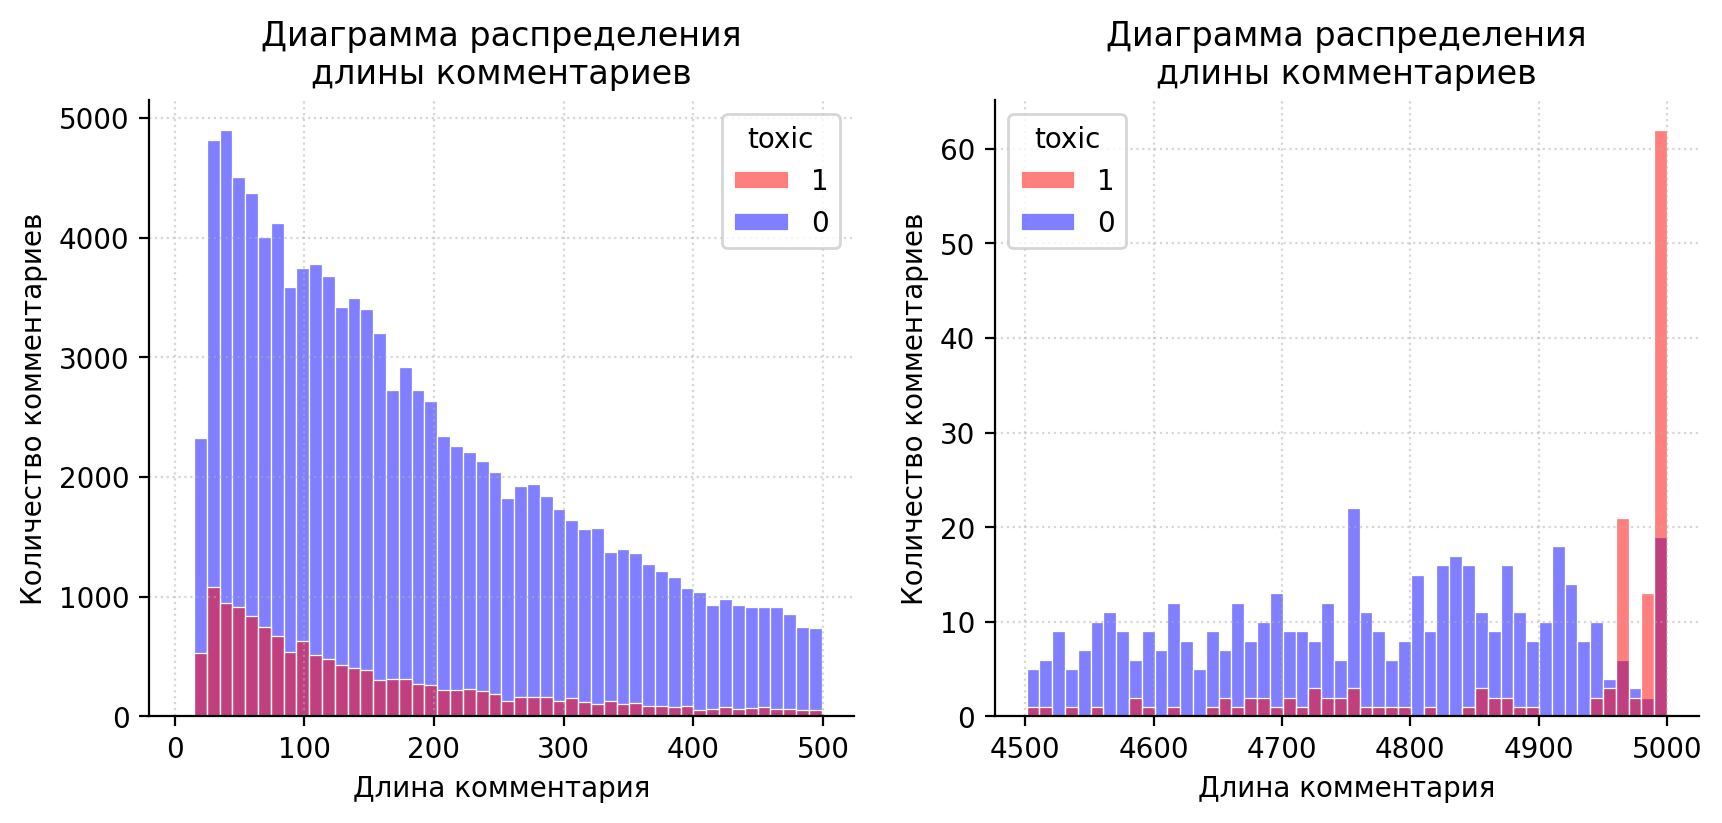

In [30]:
tails = []
tails.append(toxic_comments_df.query('text_len < 500'))
tails.append(toxic_comments_df.query('text_len > 4500'))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for i in range(2):
    sns.histplot(x=tails[i]['text_len'], 
                 hue=tails[i]['toxic'], 
                 hue_order=[1, 0], palette=['red', 'blue'],
                 bins=50, edgecolor='white', ax=axes[i])
    axes[i].set_title('Диаграмма распределения\nдлины комментариев')
    axes[i].set_xlabel('Длина комментария')
    axes[i].set_ylabel('Количество комментариев')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].grid(alpha=0.5, linestyle=':')
plt.show()

del tails

Комментарии масимальной длины (~5 тыс. символов) явно выделяются своей токсичностью. При этом большая длина обусловлена многократными повторами какой-либо фразы (отдельно выводить такие примеры не стоит из-за наличия обсценной лексики).

In [32]:
toxic_comments_df = toxic_comments_df.drop(columns=['text_len'])

Построим облака слов для токсичных и нетоксичных комментариев.

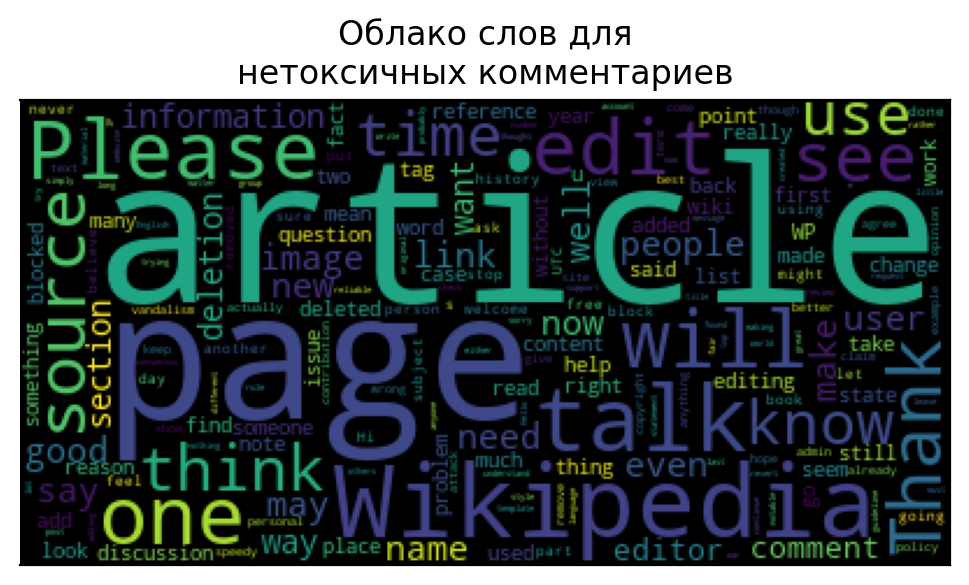

In [34]:
wordcloud = WordCloud(collocations=False, random_state=RANDOM_STATE).generate(' '.join(toxic_comments_df.query('toxic == 0')['text']))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.imshow(wordcloud)
ax.set_title('Облако слов для\nнетоксичных комментариев')
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Обучение

### Модель классификации без BERT

Будем работать с копией исходного датафрейма.

In [38]:
toxic_comments_lemma_df = toxic_comments_df.copy()

#### Подготовка

Проведем очистку и лемматизацию комментариев:
- оставим только символы аглийского алфавита;
- избавимся от многократных повторов коротких фраз (иначе они сильно взвинтят частотность слов/словосочетаний, которые в них используются);
- лемматизируем комментарии с использованием `spacy`.

In [41]:
def lemmatize_text(text: str, spacy_en_nlp: spacy) -> str:
    # Приведем к нижнему регистру
    text = text.lower()
    
    # Оставим только символы английского алфавита
    text = re.sub('[^a-z]', ' ', text)
    text = ' '.join(text.split())
    
    # Избавимся от многократных повторов коротких фраз
    if text:
        unique_threshold = 0.5
        unique_words_count_limit = 10
        
        words = text.split()
        unique_words = set(words)
        if len(unique_words) / len(words) < unique_threshold and len(unique_words) <= unique_words_count_limit:
            text = ' '.join(words[:len(unique_words)])
    
    # Проведем лемматизацию
    doc = spacy_en_nlp(text)
    text = ' '.join([token.lemma_ for token in doc])
    
    return text


spacy_en_nlp = spacy.load('en_core_web_sm')
lemmatize_text('How do you do, fellow kids?', spacy_en_nlp)

'how do you do fellow kid'

In [42]:
csv_lemma = 'datasets/lemma.csv'
if os.path.exists(csv_lemma):
    # Прочитаем лемматизированные комментарии из csv
    lemma_df = pd.read_csv(csv_lemma, index_col=0, keep_default_na=False)
else:
    # Лемматизируем комментарии и сохраним в csv
    lemma_df = pd.DataFrame({'lemma': []})
    lemma_df['lemma'] = toxic_comments_lemma_df['text'].apply(lambda x: lemmatize_text(x, spacy_en_nlp))
    lemma_df.to_csv(csv_lemma)

toxic_comments_lemma_df = toxic_comments_lemma_df.join(lemma_df)
del lemma_df

Посмотрим, что получилось в результате лемматизации.

In [44]:
toxic_comments_lemma_df.head(5)

,text,toxic,lemma
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after I vote at new york dolls fac and please don t remove the template from the talk page since I m retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he match this background colour I m seemingly stick with thank talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man I m really not try to edit war it s just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page he seem to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0,more I can t make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for formatting style on reference or want to do it yourself please let I know there appear to be a backlog on article for review so I guess there may be a delay until a reviewer tu...
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir be my hero any chance you remember what page that s on


#### Обучение

Разделим лемматизированные данные `toxic_comments_lemma_df` на тренировочную, валидационную и тестовую выборки, не забыв про стратификацию по таргету.

In [47]:
# 75% на тренировочную и валидационную выборки, 25% — на тестовую выборку
train_valid, test = train_test_split(
    toxic_comments_lemma_df,
    test_size=0.25,
    stratify=toxic_comments_lemma_df['toxic'],
    random_state=RANDOM_STATE
)

# Тренировочную и валидационную выборки делим в пропорции 4 к 1
train, valid = train_test_split(
    train_valid,
    test_size=0.2,
    stratify=train_valid['toxic'],
    random_state=RANDOM_STATE
)

X_train, y_train = train.drop('toxic', axis=1), train['toxic']
X_valid, y_valid = valid.drop('toxic', axis=1), valid['toxic']
X_test, y_test = test.drop('toxic', axis=1), test['toxic']
del train_valid, train, valid, test

X_train.shape[0], X_valid.shape[0], X_test.shape[0]

(95575, 23894, 39823)

Загрузим список стоп-слов, который будем использовать при векторизации текстов.

In [ ]:
nltk.download('stopwords')
STOPWORDS = nltk_stopwords.words('english')

In [50]:
len(STOPWORDS)

198

Обучим модель логистической регрессии на тренировочной выборке. Подберем оптимальный набор гиперпараметров поиском по сетке `GridSearchCV`. Лучшую модель выберем по результатам кросс-валидации.

На вход модели подадим векторизованные лемматизированные тексты комментариев `lemma`, для этого рассчитаем *TF-IDF* с помощью класса `TfidfVectorizer`.

In [52]:
model_pipe = Pipeline(
    steps=[('vectorizer', TfidfVectorizer(ngram_range=(1, 2), stop_words=STOPWORDS)), 
           ('model', LogisticRegression(random_state=RANDOM_STATE))]
)

param_grid = [
    {
        'model__solver': ['lbfgs'], # ['lbfgs', 'liblinear', 'saga']
        'model__penalty': ['l2'], # ['l1', 'l2']
        'model__C': [20.0], # [0.1, 1.0, 2.0, 10.0, 20.0]
        'model__class_weight': ['balanced'], # ['balanced', None]
        'model__fit_intercept': [True] # [True, False]
    }
]

splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_search_cv = GridSearchCV(
    estimator=model_pipe, 
    param_grid=param_grid, 
    cv=splitter.split(X_train, y_train),
    scoring='f1',
    n_jobs=-1
)
grid_search_cv.fit(X_train['lemma'], y_train)

f'F1 лучшей модели при кросс-валидации: {grid_search_cv.best_score_:.4f}'

'F1 лучшей модели при кросс-валидации: 0.7726'

Посмотрим на параметры лучшей модели.

In [54]:
display(grid_search_cv.best_estimator_.named_steps['model'].get_params())

{'C': 20.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Подберем оптимальный порог классификации на валидационной выборке.

In [56]:
predict_proba_valid = grid_search_cv.predict_proba(X_valid['lemma'])[:, 1]

metrics = {
    'threshold': [],
    'scores': {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
}

max_f1 = 0
threshold = 0
for i in np.arange(0.01, 1, .01):
    metrics['threshold'].append(i)
    metrics['scores']['f1'].append(f1_score(y_valid, np.where(predict_proba_valid >= i, 1, 0)))
    metrics['scores']['accuracy'].append(accuracy_score(y_valid, np.where(predict_proba_valid >= i, 1, 0)))
    metrics['scores']['precision'].append(precision_score(y_valid, np.where(predict_proba_valid >= i, 1, 0)))
    metrics['scores']['recall'].append(recall_score(y_valid, np.where(predict_proba_valid >= i, 1, 0)))

    if metrics['scores']['f1'][-1] > max_f1:
        max_f1 = metrics['scores']['f1'][-1]
        threshold = i

f'F1={max_f1:.4f} на валидационной выборке при пороге классификации {threshold}'

'F1=0.7898 на валидационной выборке при пороге классификации 0.61'

Посмотрим на зависимость метрик модели от порога классификации.

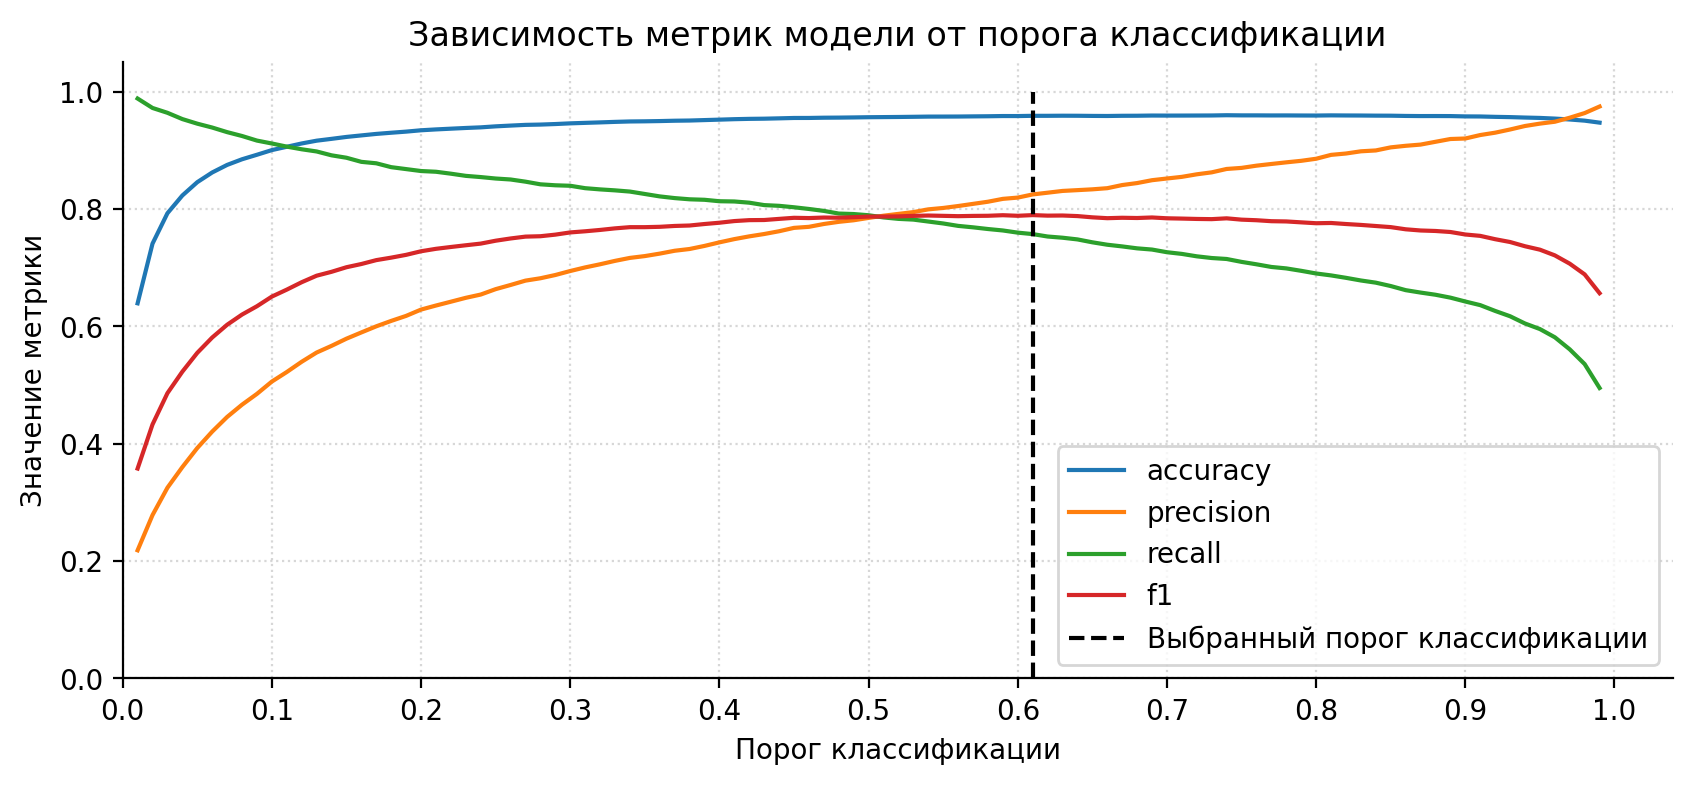

In [58]:
fig, ax = plt.subplots(figsize=(10, 4))

for key, values in metrics['scores'].items():
    ax.plot(metrics['threshold'], values, label=key)
ax.vlines(threshold, 0, 1, colors='black', label='Выбранный порог классификации', linestyles='dashed')

ax.set_title('Зависимость метрик модели от порога классификации')
ax.set_xlabel('Порог классификации')
ax.set_ylabel('Значение метрики')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.5, linestyle=':')

plt.show()

#### Результаты модели

С порогом классификации определились. Посмотрим на результаты модели на тестовой выборке.

In [61]:
predict_proba_test = grid_search_cv.predict_proba(X_test['lemma'])[:, 1]
f1_score(y_test, np.where(predict_proba_test >= threshold, 1, 0))

f'F1={max_f1:.4f} на тестовой выборке при пороге классификации {threshold}'

'F1=0.7898 на тестовой выборке при пороге классификации 0.61'

Метрика качества *F1* обученной модели логистической регресии **~0.79** (то есть модель удовлетворяет требования заказчика).

Посмотрим на n-граммы с наибольшим влиянием на присвоение нетоксичного класса.

In [64]:
ngram_coef = pd.DataFrame({
    'ngram': grid_search_cv.best_estimator_.named_steps['vectorizer'].get_feature_names_out(),
    'coef': grid_search_cv.best_estimator_.named_steps['model'].coef_[0]
}).sort_values(by='coef', ascending=False)

ngram_coef.tail(10).reset_index(drop=True)

,ngram,coef
0,version,-6.882412
1,interesting,-6.942269
2,case,-7.041820
3,section,-7.315898
4,please,-7.513855
5,talk,-7.604825
6,merge,-7.807084
7,mention,-8.178822
8,article,-8.187777
9,thank,-11.244730


In [65]:
del ngram_coef

### Модель классификации с BERT

Будем работать с копией исходного датафрейма.

In [68]:
toxic_comments_bert_df = toxic_comments_df.copy()

#### Подготовка

Проведем векторизацию комментариев с помощью предобученной модели BERT:
- укоротим длинные комментарии (самая токсичная часть в основном содержится в самом начале);
- токенизируем комментарии;
- преобразуем токены в эмбеддинги батчами.

In [71]:
csv_embeddings = 'datasets/embeddings.csv'
if os.path.exists(csv_embeddings):
    # Прочитаем эмбеддинги из csv
    embeddings_df = pd.read_csv(csv_embeddings, index_col=0)
else:
    # Используем предобученные токенизатор и модель BERT
    bert_name = 'DeepPavlov/bert-base-cased-conversational'
    bert_config = BertConfig.from_pretrained(bert_name)
    bert_tokenizer = BertTokenizer.from_pretrained(bert_name)
    bert_model = BertModel.from_pretrained(bert_name, config=bert_config)

    # Преобразуем укороченные комментарии в токены
    tokenized_text = bert_tokenizer(
        toxic_comments_bert_df['text'].apply(lambda x: x[:200]).values.tolist(), 
        add_special_tokens=True,
        padding=True,
        truncation=True,
        max_length=bert_tokenizer.model_max_length,
        return_tensors='pt'
    )

    # Преобразуем токены в эмбеддинги батчами
    batch_size = 100
    batch_count = int(np.ceil(tokenized_text['input_ids'].shape[0] / batch_size))
    for i in notebook.tqdm(range(batch_count)):
        ind_from = batch_size * i
        ind_to = min(batch_size * (i + 1), tokenized_text['input_ids'].shape[0])
        with torch.no_grad():
            batch_embeddings = bert_model(
                tokenized_text['input_ids'][ind_from:ind_to], 
                attention_mask=tokenized_text['attention_mask'][ind_from:ind_to]
            )
    
        # Сохраним батч в csv
        batch_embeddings_df = pd.DataFrame(
            batch_embeddings[0][:, 0, :].numpy(), 
            index=toxic_comments_bert_df.iloc[ind_from:ind_to].index
        )
        batch_embeddings_df.to_csv(f'{csv_embeddings}-part{i}')

    # Соберем результаты в один датафрейм и сохраним в csv
    embeddings_df = pd.DataFrame()
    for i in range(batch_count):
        batch_embeddings_df = pd.read_csv(f'{csv_embeddings}-part{i}', index_col=0)
        embeddings_df = pd.concat([embeddings_df, batch_embeddings_df])
    embeddings_df.to_csv(csv_embeddings)

toxic_comments_bert_df = toxic_comments_bert_df[['toxic']].join(embeddings_df)
del embeddings_df

Посмотрим, что получилось в результате векторизации.

In [73]:
toxic_comments_bert_df.head(5)

,toxic,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,0,0.759787,-0.222047,-0.150502,-0.167697,-0.223902,0.011834,0.305471,-0.010115,0.405379,...,0.118857,-0.121874,-0.104937,-0.710533,-0.310582,-0.174797,0.177493,-0.423449,0.240666,0.247573
1,0,0.925163,-0.852901,0.051621,0.426478,-0.484118,-0.260256,-0.182941,0.105235,0.501448,...,0.318928,0.248171,-0.062025,0.777886,-0.050984,-0.078559,-0.387917,0.427760,-0.257011,0.076730
2,0,0.728981,-0.113649,-0.121500,0.257052,-0.204453,0.093315,0.105944,-0.800002,0.624800,...,0.571237,-0.053641,-0.228817,0.056434,0.185065,-0.005380,-0.088907,-0.388161,0.440317,-0.265242
3,0,0.531194,0.040209,-0.187886,0.052276,-0.626696,0.010270,-0.110070,0.363679,0.823361,...,0.354439,-0.303669,-0.124056,0.381548,0.075880,0.298962,-0.319628,-0.519197,0.228670,0.254913
4,0,0.318323,0.269135,-0.144775,0.275048,-0.097433,0.241255,0.063793,0.426784,0.758169,...,0.497323,0.332584,-0.326148,0.104447,0.365160,-0.336998,0.190563,0.051111,0.207953,-0.237073


#### Обучение

Разделим векторизированные данные `toxic_comments_bert_df` на тренировочную, валидационную и тестовую выборки, не забыв про стратификацию по таргету.

In [76]:
# 75% на тренировочную и валидационную выборки, 25% — на тестовую выборку
train_valid, test = train_test_split(
    toxic_comments_bert_df,
    test_size=0.25,
    stratify=toxic_comments_bert_df['toxic'],
    random_state=RANDOM_STATE
)

# Тренировочную и валидационную выборки делим в пропорции 4 к 1
train, valid = train_test_split(
    train_valid,
    test_size=0.2,
    stratify=train_valid['toxic'],
    random_state=RANDOM_STATE
)

X_train, y_train = train.drop('toxic', axis=1), train['toxic']
X_valid, y_valid = valid.drop('toxic', axis=1), valid['toxic']
X_test, y_test = test.drop('toxic', axis=1), test['toxic']
del train_valid, train, valid, test

X_train.shape[0], X_valid.shape[0], X_test.shape[0]

(95575, 23894, 39823)

Определим веса классов таргета.

In [78]:
class_weights = dict(1 / (y_train.value_counts() / y_train.value_counts().max()))
class_weights

{0: 1.0, 1: 8.840918451400329}

Обучим несколько моделей на тренировочной выборке. Подберем оптимальный набор гиперпараметров поиском по сетке `GridSearchCV`. Лучшую модель выберем по результатам кросс-валидации.

In [80]:
model_pipe = Pipeline(
    steps=[('model', LogisticRegression())]
)

param_grid = [
    {
        'model': [CatBoostClassifier(verbose=False, random_state=RANDOM_STATE)],
        'model__iterations': [500], 
        'model__class_weights': [class_weights] # [class_weights, None]
    },
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__solver': ['lbfgs'], # ['lbfgs', 'liblinear', 'saga']
        'model__penalty': ['l2'], # ['l1', 'l2']
        'model__C': [1.0], # [0.1, 1.0, 2.0, 10.0, 20.0]
        'model__class_weight': [None], # ['balanced', None]
        'model__fit_intercept': [True], # [True, False]
        'model__max_iter': [1000]
    }
]

splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_search_cv = GridSearchCV(
    estimator=model_pipe, 
    param_grid=param_grid, 
    cv=splitter.split(X_train, y_train),
    scoring='f1',
    n_jobs=-1
)
grid_search_cv.fit(X_train, y_train)

f'F1 лучшей модели при кросс-валидации: {grid_search_cv.best_score_:.4f}'

'F1 лучшей модели при кросс-валидации: 0.7104'

Посмотрим на параметры лучшей модели.

In [82]:
display(grid_search_cv.best_estimator_.named_steps['model'].get_params())

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Подберем оптимальный порог классификации на валидационной выборке.

In [84]:
predict_proba_valid = grid_search_cv.predict_proba(X_valid)[:, 1]

max_f1 = 0
threshold = 0
for i in np.arange(0.01, 1, .01):
    score = f1_score(y_valid, np.where(predict_proba_valid >= i, 1, 0))
    if score > max_f1:
        max_f1 = score
        threshold = i

f'F1={max_f1:.4f} на валидационной выборке при пороге классификации {threshold}'

'F1=0.7211 на валидационной выборке при пороге классификации 0.4'

#### Результаты модели

Ни одна из тестируемых моделей не показала на кросс-валидации приемлевого качества (лучшая метрика *F1* ~0.72).

## Выводы

В ходе исследования обработан и проанализирован набор данных с разметкой о токсичности правок (комментариев) для интернет-магазина «Викишоп». Построены модели классификации комментариев для дальнейшей отправки токсичных комментариев на модерацию. Построенные модели проанализированы, и выбрана модель, наиболее подходящая под критерий оценки качества.

В результате **предобработки данных** пропусков и дубликатов не обнаружено. **Анализ данных** позволил обнаружить дисбаланс классов (негативных комментариев на порядок меньше, чем позитивных).

При решении задачи было использовано два подхода:
- Обучение моделей на векторизованных лемматизированных комментариях на основе частотности *TF-IDF*.
- Обучение моделей на векторизованных комментариях с помощью предобученной языковой модели *BERT*.

По результатам **обучения и анализа качества моделей**, классифицирующих комментарии, рекомендуется использовать модель логистической регрессии `LogisticRegression` с предварительной векторизацией текстов на основе частотности *TF-IDF*. Метрика качества *F1* обученной модели логистической регресии **~0.79** (то есть модель удовлетворяет требования заказчика).

Модели, для которых входными признаками служили векторизованные комментарияи с помощью предобученной языковой модели *BERT*, не достигли требуемого уровня качества. 

Подход, основанный на простом использовании *TF-IDF*, дает лучший результат, чем поиск сложных лингвистических связей с помощью языковой модели *BERT*, затрачивая при этом гораздо меньше вычислительных ресурсов. Этот подход позволяет модели классификации «уловить», например, что в токсичных комметариях чаще используются слова/словосочетания из обсценной лексики.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны